#### Matplotlib and Seaborn Visualizations for Final Prez

In [1]:
import warnings
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### Read in User-Level Yelp Data

In [2]:
user = pd.read_pickle("data/yelp/dataframes/yelp_review_user.pkl")
user.head(5)

,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115
2,--GQemub1KP4qMaA2GYPdA,5,3,2,0,10,12
3,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31
4,--JjLDsPnBf39VR7JTLlSA,1,0,0,0,1,2


#### Subset to Top 25 Percentile of Users

In [3]:
user = user[(user.relevant>=12) & (user.relevant<=222)]
user.reset_index(drop=True, inplace=True)

#### Calculate % in Each Topic

In [4]:
user["pct_food"] = user["topic_food"] / user["relevant"]
user["pct_service"] = user["topic_service"] / user["relevant"]
user["pct_ambience"] = user["topic_ambience"] / user["relevant"]
user["pct_value"] = user["topic_value"] / user["relevant"]
user.head(5)

,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90,0.673913,0.173913,0.282609,0.108696
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115,0.666667,0.194444,0.236111,0.236111
2,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31,0.666667,0.208333,0.166667,0.000000
3,--JzqHAkaNejih4O2O9jjw,13,7,3,0,18,23,0.722222,0.388889,0.166667,0.000000
4,--f43ruUt7LBeB3aU74z-w,23,4,4,0,27,47,0.851852,0.148148,0.148148,0.000000


#### Cluster Users Using K-Means

In [5]:
def kmeans(df, varlist, n_clusters):
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=4444)
    clusters = pd.Series(model.fit_predict(df[varlist]), name="cluster")
    clustered = pd.concat([df, clusters], axis=1)
    
    print clustered["cluster"].nunique()
    print clustered["cluster"].value_counts()
    print clustered.groupby(by="cluster")[varlist].mean()
    
    return clustered

In [6]:
varlist = ["pct_food","pct_service","pct_ambience","pct_value"]
clustered = kmeans(user, varlist, n_clusters=4)
clustered.head(5)

4
3    5724
1    4671
0    3520
2    1648
Name: cluster, dtype: int64
         pct_food  pct_service  pct_ambience  pct_value
cluster                                                
0        0.569150     0.216550      0.310050   0.112562
1        0.617186     0.341719      0.136070   0.105455
2        0.389265     0.577332      0.153612   0.096132
3        0.782606     0.156507      0.129342   0.097690


,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value,cluster
0,--9jRaeY1xK-2l9r9fVQWA,31,8,13,5,46,90,0.673913,0.173913,0.282609,0.108696,0
1,--ECBYLVpIfQaeX_35i63Q,48,14,17,17,72,115,0.666667,0.194444,0.236111,0.236111,0
2,--JM6F4TP_gwzIuw9QSRbA,16,5,4,0,24,31,0.666667,0.208333,0.166667,0.000000,3
3,--JzqHAkaNejih4O2O9jjw,13,7,3,0,18,23,0.722222,0.388889,0.166667,0.000000,1
4,--f43ruUt7LBeB3aU74z-w,23,4,4,0,27,47,0.851852,0.148148,0.148148,0.000000,3


#### Format Dataframe to Read into Seaborn Barplot

In [7]:
def stack_data(df, var, topic):
    new_df = df.rename(columns={var: "percent"}) #rename column for stacking
    new_df["percent"] = new_df.percent.apply(lambda x: x*100)
    new_df["topic"] = topic #flag topic
    
    return new_df[["user_id","topic","percent","cluster"]]

In [8]:
food = stack_data(clustered, "pct_food", "Food & \nDrink")
service = stack_data(clustered, "pct_service", "Service")
ambience = stack_data(clustered, "pct_ambience", "Ambience")
value = stack_data(clustered, "pct_value", "Value")

stacked = pd.concat([food, service, ambience, value], axis=0)
print stacked.head(5)

                  user_id           topic    percent  cluster
0  --9jRaeY1xK-2l9r9fVQWA  Food & \nDrink  67.391304        0
1  --ECBYLVpIfQaeX_35i63Q  Food & \nDrink  66.666667        0
2  --JM6F4TP_gwzIuw9QSRbA  Food & \nDrink  66.666667        3
3  --JzqHAkaNejih4O2O9jjw  Food & \nDrink  72.222222        1
4  --f43ruUt7LBeB3aU74z-w  Food & \nDrink  85.185185        3


#### Visualize Clusters

##### Seaborn Color Palettes

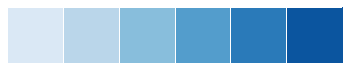

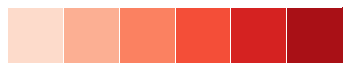

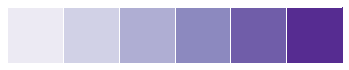

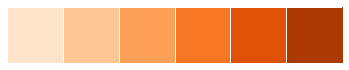

In [9]:
sns.palplot(sns.color_palette("Blues"))
sns.palplot(sns.color_palette("Reds"))
sns.palplot(sns.color_palette("Purples"))
sns.palplot(sns.color_palette("Oranges"))

##### Format Percent Tick Marks

In [10]:
def to_percent(x, position):
    s = str(x)

    if mpl.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)

##### Plot!

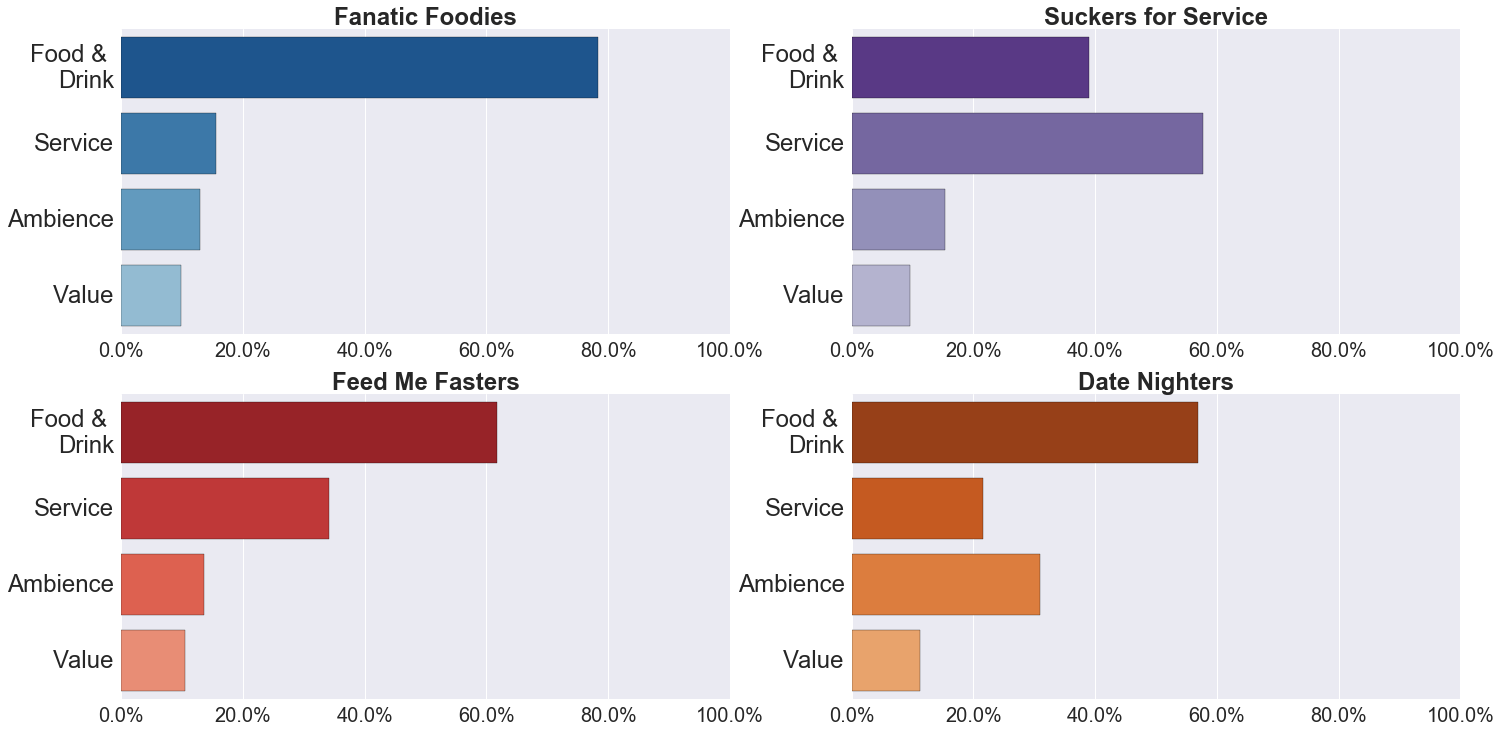

In [11]:
plt.figure(figsize=(24,12))

blues = sns.color_palette("Blues")[6:1:-1]
purples = sns.color_palette("Purples")[6:1:-1]
reds = sns.color_palette("Reds")[6:1:-1]
oranges = sns.color_palette("Oranges")[6:1:-1]

plt.subplot(2,2,1)
sns.barplot(x="percent", y="topic", orient="h", ci=None, palette=blues, data=stacked[stacked.cluster==3])
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=24)
plt.xlabel("")
plt.ylabel("")
plt.title("Fanatic Foodies", fontsize=24, fontweight="bold")
pylab.xlim([0,100])
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(2,2,2)
sns.barplot(x="percent", y="topic", orient="h", ci=None, palette=purples, data=stacked[stacked.cluster==2])
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=24)
plt.xlabel("")
plt.ylabel("")
plt.title("Suckers for Service", fontsize=24, fontweight="bold")
pylab.xlim([0,100])
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(2,2,3)
sns.barplot(x="percent", y="topic", orient="h", ci=None, palette=reds, data=stacked[stacked.cluster==1])
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=24)
plt.xlabel("")
plt.ylabel("")
plt.title("Feed Me Fasters", fontsize=24, fontweight="bold")
pylab.xlim([0,100])
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplot(2,2,4)
sns.barplot(x="percent", y="topic", orient="h", ci=None, palette=oranges, data=stacked[stacked.cluster==0])
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=24)
plt.xlabel("")
plt.ylabel("")
plt.title("Date Nighters", fontsize=24, fontweight="bold")
pylab.xlim([0,100])
plt.gca().xaxis.set_major_formatter(formatter)

plt.savefig("graphics/topic_dist_by_cluster.png")

##### Output Clustered Data for D3 Interactive Bar Graph (for Blog)

In [12]:
grouped = stacked.groupby(by=["cluster","topic"], as_index=False)["percent"].mean()

##Clean Up a Bit
grouped.ix[grouped.topic=="Food & \nDrink", "topic"] = "Food & Drink"
grouped.ix[grouped.cluster==3, "cluster"] = "fanatic_foodies"
grouped.ix[grouped.cluster==2, "cluster"] = "suckers_for_service"
grouped.ix[grouped.cluster==1, "cluster"] = "feed_me_fasters"
grouped.ix[grouped.cluster==0, "cluster"] = "date_nighters"

grouped["percent"] = grouped.percent / 100 #percents back on 0-1 scale
grouped

,cluster,topic,percent
0,date_nighters,Ambience,0.310050
1,date_nighters,Food & Drink,0.569150
2,date_nighters,Service,0.216550
3,date_nighters,Value,0.112562
4,feed_me_fasters,Ambience,0.136070
5,feed_me_fasters,Food & Drink,0.617186
6,feed_me_fasters,Service,0.341719
7,feed_me_fasters,Value,0.105455
8,suckers_for_service,Ambience,0.153612
9,suckers_for_service,Food & Drink,0.389265


In [13]:
grouped.to_csv("graphics/d3/clusters.csv", index=False)
grouped.to_csv("graphics/d3/clusters.tsv", sep="\t", index=False)

grouped[grouped.cluster=="fanatic_foodies"].to_csv("graphics/d3/foodies.csv", index=False)
grouped[grouped.cluster=="fanatic_foodies"].to_csv("graphics/d3/foodies.tsv", sep="\t", index=False)